In [ ]:
!pip install evaluate

In [ ]:
!pip install --upgrade transformers accelerate peft

In [ ]:
!pip uninstall -y transformers
!pip install --upgrade transformers accelerate peft datasets

Found existing installation: transformers 4.55.2
Uninstalling transformers-4.55.2:
  Successfully uninstalled transformers-4.55.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 46.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string
from pathlib import Path

from collections import Counter
import random
import operator
from tqdm import tqdm
import time

from wordcloud import WordCloud
from string import punctuation
import nltk
import subprocess

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers import BertModel, BertTokenizer

from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate

%matplotlib inline

In [ ]:
import kagglehub
import os
import pandas as pd
from google.colab import userdata

# Authenticate with Kaggle using the saved secrets
# Ensure your secrets KAGGLE_USERNAME and KAGGLE_KEY are set up
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# Download the dataset and get the correct Colab path
path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

# Construct the full, correct file path for Colab
csv_file_path = os.path.join(path, "HateSpeechDatasetBalanced.csv")

print(f"Correct path in Colab is: {csv_file_path}")

# Load the data using the correct path
try:
    data_full = pd.read_csv(csv_file_path)

    print("\n✅ Dataset loaded successfully!")
    display(data_full.head())

except FileNotFoundError:
    print(f"❌ Error: The file was not found at the expected path. Please check the filename.")
except Exception as e:
    print(f"An error occurred: {e}")

Correct path in Colab is: /kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv

✅ Dataset loaded successfully!


,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


In [ ]:
data_full.groupby('Label').count()

,Content
Label,
0,361594
1,364525


In [ ]:
#The dataset is quite big so we take just 4000 examples of each class
df1 = data_full.query('Label == 0').sample(4000)
df2 = data_full.query('Label == 1').sample(4000)
data = pd.concat([df1, df2], ignore_index=True)

data.shape

(8000, 2)

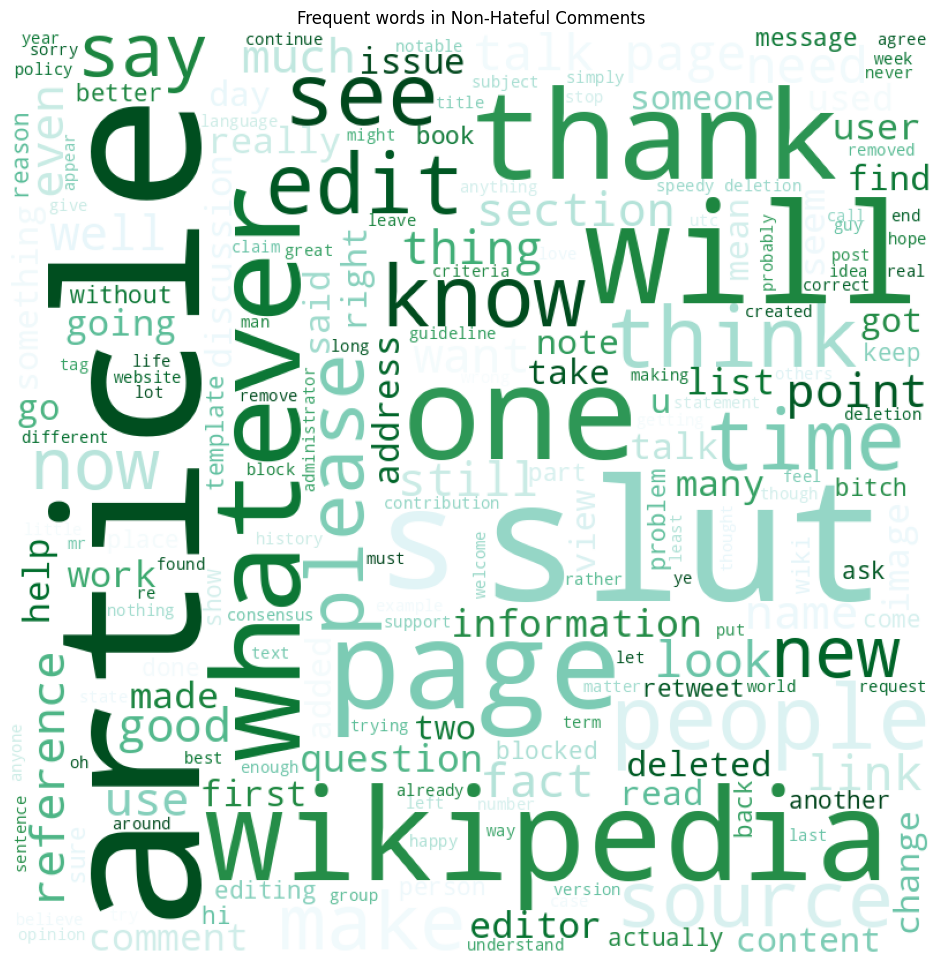

In [ ]:
combined_title = ' '.join(df1['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'BuGn',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Non-Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

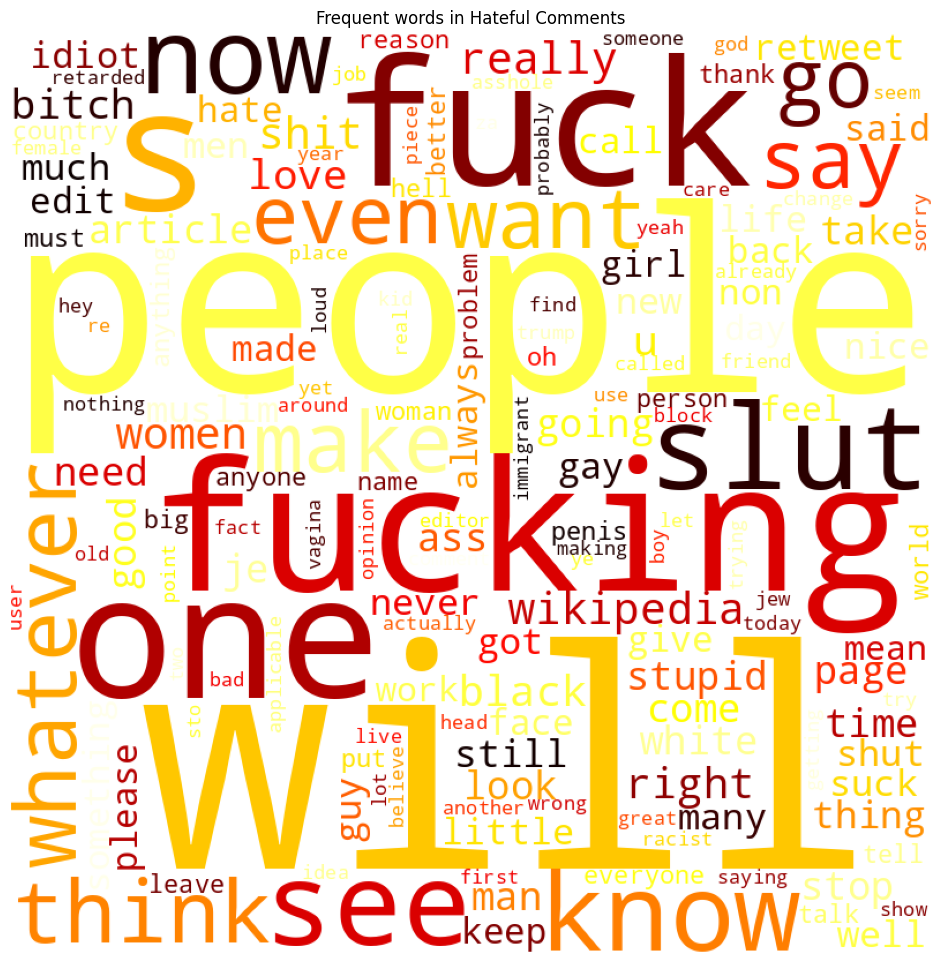

In [ ]:
combined_title = ' '.join(df2['Content'])

wordcloud_img = WordCloud(width = 800, height = 800,
                            background_color ='white', colormap = 'hot_r',
                            min_font_size = 10).generate(combined_title)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud_img)
plt.axis('off')
plt.title('Frequent words in Hateful Comments')
plt.tight_layout(pad=2)
plt.show()

In [ ]:
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data_tfidf = data.copy()

In [ ]:
import nltk

# Download the list of stopwords
nltk.download('stopwords')

# Download the tokenizer models (needed for word_tokenize)
nltk.download('punkt')

# Download the WordNet database (needed for the lemmatizer)
nltk.download('wordnet')

print("\n✅ NLTK data downloaded successfully!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...



✅ NLTK data downloaded successfully!


[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
stopwords_l = stopwords.words('english')

punctuation = re.compile("[" + re.escape(string.punctuation) + "]")

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') #Snowball stemmer initialised

def text_cleaning(text, mode="stemming"):
    res = []
    text_clean = re.sub(punctuation,'',text)
    tokens = word_tokenize(text_clean)

    for token in tokens:
        if token.lower() not in stopwords_l:
            if mode == "stemming":
                prepared_word = stemmer.stem(token)
            else:
                prepared_word = lemmatizer.lemmatize(token)
            res.append(prepared_word)
    return ' '.join(res)

In [ ]:
import nltk
import pandas as pd # Make sure pandas is imported

# Step 1: Download all necessary NLTK data packets
# This ensures they are always available before the cleaning function runs.
# We are also adding 'punkt_tab' as your error message specifically requested it.
nltk.download('punkt')
nltk.download('punkt_tab') # Added based on the error message
nltk.download('stopwords')
nltk.download('wordnet')

print("\n✅ NLTK data is ready.")

# Step 2: Apply your text_cleaning function
# This code will now run without a LookupError.
try:
    print("Applying text cleaning...")
    # Assuming 'data_tfidf' is your DataFrame and 'text_cleaning' is your function
    data_tfidf['cleaned_text'] = data_tfidf['Content'].apply(text_cleaning)
    print("Text cleaning complete.")
    display(data_tfidf.head())
except NameError:
    print("\n❌ Make sure your DataFrame 'data_tfidf' and your 'text_cleaning' function have been defined in a cell above this one.")
except Exception as e:
    print(f"\n❌ An error occurred: {e}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



✅ NLTK data is ready.
Applying text cleaning...
Text cleaning complete.


,Content,Label,cleaned_text
0,speedy deletion of of famous people with a pag...,0,speedi delet famous peopl page creat list famo...
1,this information is incorrect,0,inform incorrect
2,two of the lists have already been deleted by ...,0,two list alreadi delet afd stand reason well p...
3,some friendly and genteel comments from your c...,0,friend genteel comment civil polic tread care ...
4,basic income dispute resolution i do not under...,0,basic incom disput resolut understand find fut...


In [ ]:
train, test = train_test_split(data_tfidf, test_size=0.3, stratify=data['Label'], random_state=42)

X_train = train['cleaned_text']
y_train = train['Label']

X_test = test['cleaned_text']
y_test = test['Label']

In [ ]:
# TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = tfidf_vectorizer.fit_transform(X_train)

X_test_vect = tfidf_vectorizer.transform(X_test)

In [ ]:
linear_clf = LogisticRegression()

# train the model with training data processed using TF-IDF
linear_clf.fit(X_train_vect, y_train)

LogisticRegression()

In [ ]:
y_pred_tf_idf = linear_clf.predict(X_test_vect)


report = classification_report(y_test, y_pred_tf_idf)
print(report)

display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 0],
              "Predicted: Hateful": confusion_matrix(y_test, y_pred_tf_idf)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1200
           1       0.75      0.79      0.77      1200

    accuracy                           0.76      2400
   macro avg       0.77      0.76      0.76      2400
weighted avg       0.77      0.76      0.76      2400



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,889,311
Actual: Hateful,254,946


Bert

In [ ]:
train, validation = train_test_split(data, test_size=0.3, stratify=data['Label'], random_state=42)

In [ ]:
# Define Dataset
class HateSpeechDataset(Dataset):

    def __init__(self, data):

        # Initialize BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.data = data


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data.iloc[idx]

        text = example["Content"]
        label = example["Label"]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"], ##.unsqueeze(0).int(),
            "label": label,
        }


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset_train = HateSpeechDataset(train)
dataset_val = HateSpeechDataset(validation)

#data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create DataLoader
batch_size = 128
dataloader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

dataloader_val = DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: {
        "input_ids": torch.stack([item["input_ids"] for item in x]),
        "attention_mask": torch.stack([item["attention_mask"] for item in x]),
        "labels": torch.tensor([item["label"] for item in x])
    },
    #collate_fn=data_collator,
    pin_memory=True,
)

In [ ]:
# Define BERT classifier
class BERTClassifier(nn.Module):

    def __init__(self):

        # Specify network layers
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        self.linear = nn.Linear(self.bert.config.hidden_size, 1)

        # Define dropout
        self.dropout = nn.Dropout(0.1)

        # Freeze BERT layers
        for n, p in self.bert.named_parameters():
            p.requires_grad = False

    def forward(self, text, masks):
        #output_bert = self.bert(text, attention_mask=masks).last_hidden_state.mean(axis=1)
        #print(output_bert.last_hidden_state)
        #print(self.bert.config.hidden_size)

        output_bert = self.bert(text, attention_mask=masks).last_hidden_state
        output_bert = self.avg_pool(output_bert.transpose(1, 2)).squeeze(-1)

        return self.linear(self.dropout(output_bert))

In [ ]:
model = BERTClassifier()

In [ ]:
# Define optimiser, objective function and epochs
optimizer = optim.Adam(model.parameters(), lr=0.001) #optim.AdamW(model.parameters(), lr=5e-5) #
criterion = nn.BCEWithLogitsLoss()
epochs = 5

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model.to(device)

val_losses = []
train_losses = []

# Train model
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    model.train()
    print(f"Start training epoch {epoch_i}...")
    total_train_loss = 0
    for i, batch in enumerate(tqdm(dataloader_train)):

        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)

        output = model(input_ids, masks)
        loss = criterion(output.squeeze(), label.float())

        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent the "exploding gradients".
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(dataloader_train)
    train_losses.append(avg_train_loss)
    # ========================================
    #               Validation
    # ========================================

    model.eval()
    print("Start validation...")
    y_true_bert = list()
    y_pred_bert = list()

    total_eval_loss = 0.0
    with torch.no_grad():
        for batch in dataloader_val:
            input_ids = batch['input_ids'].to(device)
            masks = batch['attention_mask'].to(device)
            label = batch['labels'].to(device)

            output = model(input_ids, masks)
            max_output = (torch.sigmoid(output).cpu().numpy().reshape(-1)>= 0.5).astype(int)
            y_true_bert.extend(label.tolist())
            y_pred_bert.extend(max_output.tolist())

            loss_v = criterion(output.squeeze(), label.float())
            total_eval_loss += loss.item()
    avg_val_loss = total_eval_loss / len(dataloader_val)
    val_losses.append(avg_val_loss)

    print(f"Metrics after Epoch {epoch_i}")
    print(f"Accuracy : {accuracy_score(y_true_bert, y_pred_bert)}")
    print(f"Presision: {np.round(precision_score(y_true_bert, y_pred_bert),3)}")
    print(f"Recall: {np.round(recall_score(y_true_bert, y_pred_bert),3)}")
    print(f"F1: {np.round(f1_score(y_true_bert, y_pred_bert),3)}")
    print("   ")


Start training epoch 0...


100%|██████████| 44/44 [00:17<00:00,  2.47it/s]

Start validation...


Metrics after Epoch 0
Accuracy : 0.735
Presision: 0.726
Recall: 0.755
F1: 0.74
   
Start training epoch 1...


100%|██████████| 44/44 [00:18<00:00,  2.38it/s]

Start validation...


Metrics after Epoch 1
Accuracy : 0.7470833333333333
Presision: 0.761
Recall: 0.72
F1: 0.74
   
Start training epoch 2...


100%|██████████| 44/44 [00:20<00:00,  2.19it/s]

Start validation...


Metrics after Epoch 2
Accuracy : 0.7545833333333334
Presision: 0.765
Recall: 0.736
F1: 0.75
   
Start training epoch 3...


100%|██████████| 44/44 [00:19<00:00,  2.24it/s]

Start validation...


Metrics after Epoch 3
Accuracy : 0.7541666666666667
Presision: 0.774
Recall: 0.718
F1: 0.745
   
Start training epoch 4...


100%|██████████| 44/44 [00:20<00:00,  2.16it/s]

Start validation...


Metrics after Epoch 4
Accuracy : 0.7654166666666666
Presision: 0.77
Recall: 0.757
F1: 0.763
   


In [ ]:
print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_bert, y_pred_bert)))
print('\nClassification report: \n', classification_report(y_true_bert, y_pred_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 0],
              "Predicted: Hateful": confusion_matrix(y_true_bert, y_pred_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Test accuracy: 0.77

Classification report: 
               precision    recall  f1-score   support

           0       0.76      0.77      0.77      1200
           1       0.77      0.76      0.76      1200

    accuracy                           0.77      2400
   macro avg       0.77      0.77      0.77      2400
weighted avg       0.77      0.77      0.77      2400


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,929,271
Actual: Hateful,292,908


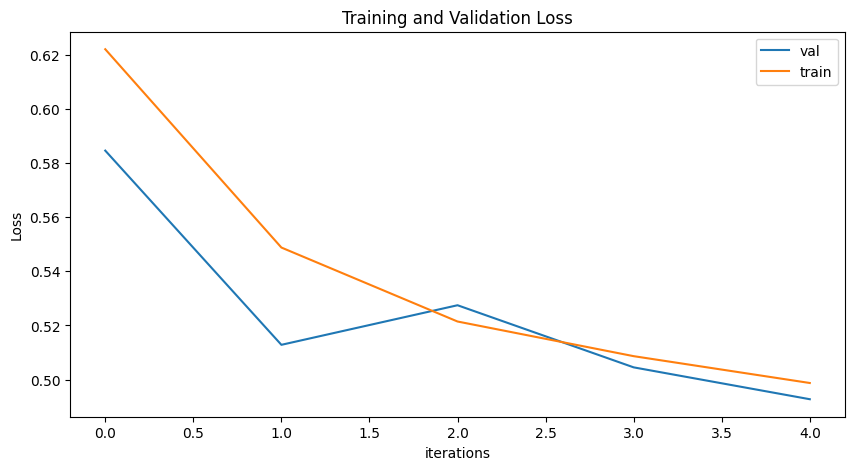

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Fine-tuning a model with the Trainer API

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=2)
training_args = TrainingArguments(output_dir="test_trainer", report_to="none")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric_acc = evaluate.load("accuracy")
metric_prec = evaluate.load("precision")
metric_recall = evaluate.load("recall")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    prec = metric_prec.compute(predictions=predictions, references=labels)["precision"]
    rec = metric_recall.compute(predictions=predictions, references=labels)["recall"]

    return {"accuracy": acc,"precision": prec, "recall": rec}

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
    data_collator = data_collator

)

In [ ]:
trainer.train()

Step,Training Loss
500,0.512200
1000,0.356800
1500,0.246000
2000,0.125900


TrainOutput(global_step=2100, training_loss=0.30206108184087843, metrics={'train_runtime': 347.339, 'train_samples_per_second': 48.368, 'train_steps_per_second': 6.046, 'total_flos': 552533216256000.0, 'train_loss': 0.30206108184087843, 'epoch': 3.0})

In [ ]:
model.eval()
print("Start validation...")
y_true_auto_bert  = list()
y_pred_auto_bert = list()

total_eval_loss = 0.0
with torch.no_grad():
    for batch in dataloader_val:
        input_ids = batch['input_ids'].to(device)
        masks = batch['attention_mask'].to(device)
        label = batch['labels'].to(device)

        output = model(input_ids, masks)
        max_output = np.argmax(output.logits.cpu().numpy(), axis=-1)
        y_true_auto_bert.extend(label.tolist())
        y_pred_auto_bert.extend(max_output.tolist())


print(f"Accuracy : {accuracy_score(y_true_auto_bert, y_pred_auto_bert)}")
print(f"Presision: {np.round(precision_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print(f"Recall: {np.round(recall_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print(f"F1: {np.round(f1_score(y_true_auto_bert, y_pred_auto_bert),3)}")
print("   ")


print('Test accuracy: {:.2f}'.format(accuracy_score(y_true_auto_bert, y_pred_auto_bert)))
print('\nClassification report: \n', classification_report(y_true_auto_bert, y_pred_auto_bert))
print('\nConfusion matrix: \n')
display(pd.DataFrame({"Predicted: Unhateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 0],
              "Predicted: Hateful": confusion_matrix(y_true_auto_bert, y_pred_auto_bert)[:, 1]},
             index=['Actual: Unhateful', 'Actual: Hateful']))

Start validation...
Accuracy : 0.835
Presision: 0.881
Recall: 0.774
F1: 0.824
   
Test accuracy: 0.83

Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.90      0.84      1200
           1       0.88      0.77      0.82      1200

    accuracy                           0.83      2400
   macro avg       0.84      0.83      0.83      2400
weighted avg       0.84      0.83      0.83      2400


Confusion matrix: 



,Predicted: Unhateful,Predicted: Hateful
Actual: Unhateful,1075,125
Actual: Hateful,271,929


rOBERTA

In [ ]:
import kagglehub
import os
import pandas as pd
from google.colab import userdata

# Authenticate with Kaggle using the saved secrets
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# Download the dataset and get the correct Colab path
path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")
csv_file_path = os.path.join(path, "HateSpeechDatasetBalanced.csv")

print(f"Correct path in Colab is: {csv_file_path}")

# Load the data using the correct path
try:
    data_full = pd.read_csv(csv_file_path)
    print("\n✅ Raw dataset loaded successfully!")

    # --- FIX: Create the 'final_df' DataFrame ---
    # This is the part that was missing.
    df = data_full.copy() # Work on a copy
    df['HS'] = df['Label'].apply(lambda x: 1 if x == 'hate_speech' else 0)
    df.rename(columns={'Content': 'text'}, inplace=True)
    final_df = df[['text', 'HS']] # Create the final_df

    print("\n✅ 'final_df' created successfully and is ready for visualization!")
    display(final_df.head())

except FileNotFoundError:
    print(f"❌ Error: The file was not found at the expected path.")
except Exception as e:
    print(f"An error occurred: {e}")

Correct path in Colab is: /kaggle/input/hate-speech-detection-curated-dataset/HateSpeechDatasetBalanced.csv

✅ Raw dataset loaded successfully!

✅ 'final_df' created successfully and is ready for visualization!


,text,HS
0,denial of normal the con be asked to comment o...,0
1,just by being able to tweet this insufferable ...,0
2,that is retarded you too cute to be single tha...,0
3,thought of a real badass mongol style declarat...,0
4,afro american basho,0


Calculating comment length over the given dataset.


  0%|          | 0/726119 [00:00<?, ?it/s]

Done with sentence length calculation.
Creating the comment length distribution plot:


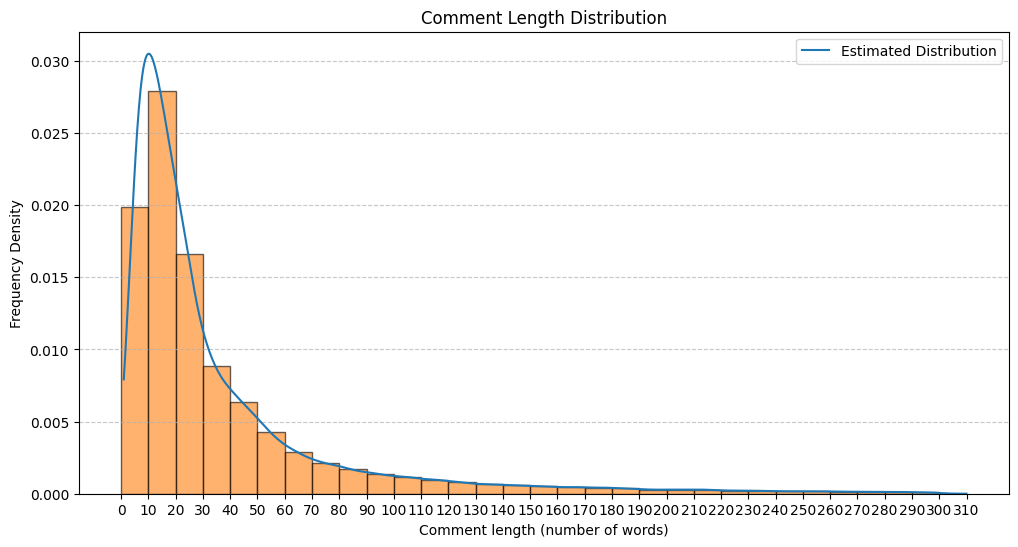


Performing language classification over the given dataset:


  0%|          | 0/726119 [00:00<?, ?it/s]

Done with language classification.
Creating the language distribution plot:


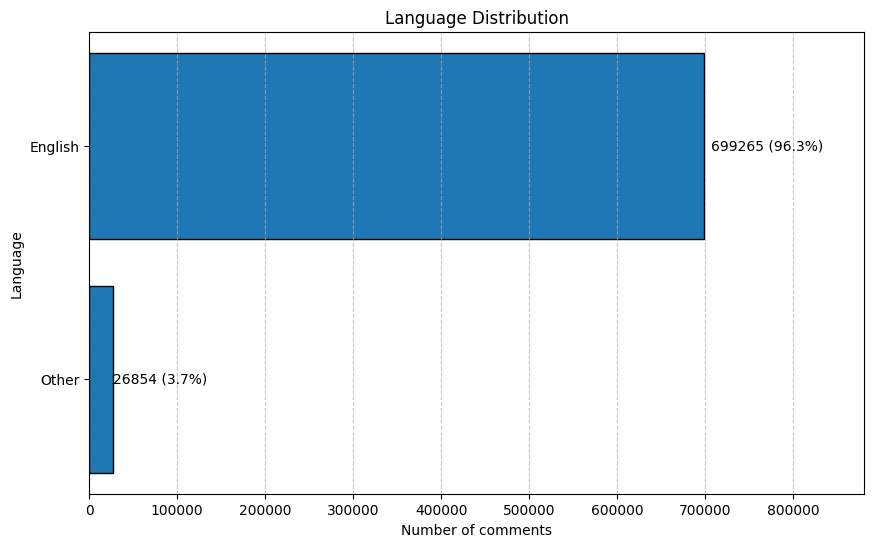

In [ ]:
# ============== VISUALIZATIONS ==============
# This cell analyzes and plots the distribution of comment lengths and languages.
# ----------------------------------------------------

# Step 1: Install necessary libraries for language detection
!pip install -q langid langcodes

# Step 2: Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import langid
import langcodes
from scipy.stats import gaussian_kde

# Initialize tqdm for pandas so we can see progress bars on .apply()
tqdm.pandas()

# --- Function to analyze and plot word length distribution ---
def word_length_distribution(df: pd.DataFrame):
    """Calculates and plots the distribution of word lengths in a DataFrame."""
    print("Calculating comment length over the given dataset.")

    # Helper function to count words
    def sentence_word_length(sentence: str):
        # Ensure the input is a string to prevent errors
        if not isinstance(sentence, str):
            return 0
        return len(sentence.split())

    # Create a new column with the word count for each comment
    df["WordLength"] = df["text"].progress_apply(sentence_word_length)
    print("Done with sentence length calculation.")

    lengths = df["WordLength"].tolist()

    print("Creating the comment length distribution plot:")
    kde = gaussian_kde(lengths)
    fig, ax = plt.subplots(figsize=(12, 6))

    ax.set_xlabel("Comment length (number of words)")
    ax.set_ylabel("Frequency Density")
    ax.set_title("Comment Length Distribution")

    # Plot the smooth distribution line and the histogram bars
    x = np.linspace(min(lengths), max(lengths), 1000)
    bin_values = np.arange(0, max(lengths) + 10, 10)
    ax.plot(x, kde(x), label="Estimated Distribution")
    ax.hist(lengths, alpha=0.6, edgecolor="black", density=True, bins=bin_values)
    ax.legend()
    ax.set_xticks(bin_values)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

# --- Functions to analyze and plot language distribution ---
def identify_language(sentence: str):
    """Identifies the language of a given sentence."""
    # Ensure the input is a string
    if not isinstance(sentence, str):
        return "Unknown"
    lang, _ = langid.classify(sentence)
    return langcodes.Language.get(lang).display_name()

def language_distribution(df: pd.DataFrame, threshold: float = 0.01):
    """Classifies and plots the language distribution in a DataFrame."""
    print("\nPerforming language classification over the given dataset:")
    df["Language"] = df["text"].progress_apply(identify_language)
    print("Done with language classification.")

    value_counts = df["Language"].value_counts().to_dict()

    # Group small language counts into an 'Other' category
    total = sum(value_counts.values())
    final_counts = {}
    other_count = 0
    # Sort for consistent ordering
    sorted_counts = sorted(value_counts.items(), key=lambda item: item[1], reverse=True)

    for key, value in sorted_counts:
        if value / total >= threshold:
            final_counts[key] = value
        else:
            other_count += value
    if other_count > 0:
        final_counts["Other"] = other_count

    print("Creating the language distribution plot:")
    fig, ax = plt.subplots(figsize=(10, 6))
    languages = list(final_counts.keys())
    counts = list(final_counts.values())

    bars = ax.barh(languages, counts, edgecolor="black")
    ax.set_xlabel("Number of comments")
    ax.set_ylabel("Language")
    ax.set_title("Language Distribution")
    ax.invert_yaxis()  # Display the most common language at the top

    # Add percentage labels to the bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width * 1.01, bar.get_y() + bar.get_height()/2,
                f'{width} ({width/total:.1%})',
                va='center', ha='left')

    ax.set_xlim(right=ax.get_xlim()[1] * 1.2) # Make space for labels
    plt.grid(True, axis='x', linestyle='--', alpha=0.7)
    plt.show()

# --- Execute the analysis on your DataFrame ---
# This code checks if 'final_df' exists before running
if 'final_df' in locals():
    # Use .copy() to avoid SettingWithCopyWarning from pandas
    df_for_eda = final_df.copy()
    word_length_distribution(df_for_eda)
    language_distribution(df_for_eda)
else:
    print("❌ Error: The DataFrame 'final_df' was not found. Please make sure you have run the data loading cells.")


LSTM

In [53]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import  Input,Dense,Embedding, LSTM,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


In [50]:
data_full['Label'].unique()

array([1, 0])

preprocessing data

In [56]:
stp = set(stopwords.words("english"))

# Function to preprocess text
def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    words = [word for word in text if word not in stp]
    return " ".join(words)
data_full['ProcessedContent'] = data_full['Content'].apply(preprocess_text)

Tokenizing data

In [59]:
from keras._tf_keras.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_full['ProcessedContent'])
sequences = tokenizer.texts_to_sequences(data_full['ProcessedContent'])

In [60]:
max_len=max([max(0,len(seq)) for seq in sequences])
max_len

294

padding and creating y label

In [61]:
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences
x = pad_sequences(sequences, maxlen=max_len)
y = data_full['Label'].values

In [62]:
print(x.shape)
print(y.shape)

(726119, 294)
(726119,)


training and splitting data

In [63]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(580895, 294)
(145224, 294)
(580895,)
(145224,)


In [64]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

creating and applying the model

In [65]:
#Creating the model
i = Input(shape=(x_train.shape[1],))
x = Embedding(input_dim=len(tokenizer.word_index)+1,output_dim=20)(i)
x = LSTM(10,return_sequences=True)(x)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(1,activation='sigmoid')(x)
model = Model(i,x)

# Using Adam optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

# Compiling the model
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Fitting the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test),batch_size=64)

Epoch 1/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 236s 25ms/step - accuracy: 0.8107 - loss: 0.4025 - val_accuracy: 0.8627 - val_loss: 0.3137
Epoch 2/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 198s 22ms/step - accuracy: 0.8800 - loss: 0.2763 - val_accuracy: 0.8662 - val_loss: 0.3058
Epoch 3/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 201s 22ms/step - accuracy: 0.8972 - loss: 0.2386 - val_accuracy: 0.8649 - val_loss: 0.3155
Epoch 4/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 199s 22ms/step - accuracy: 0.9069 - loss: 0.2168 - val_accuracy: 0.8639 - val_loss: 0.3312
Epoch 5/5
9077/9077 ━━━━━━━━━━━━━━━━━━━━ 224s 24ms/step - accuracy: 0.9120 - loss: 0.2057 - val_accuracy: 0.8622 - val_loss: 0.3334


visualization of the model

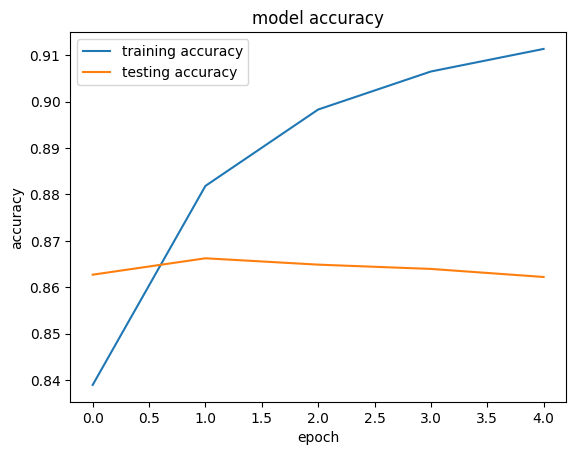

In [66]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="testing accuracy")
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

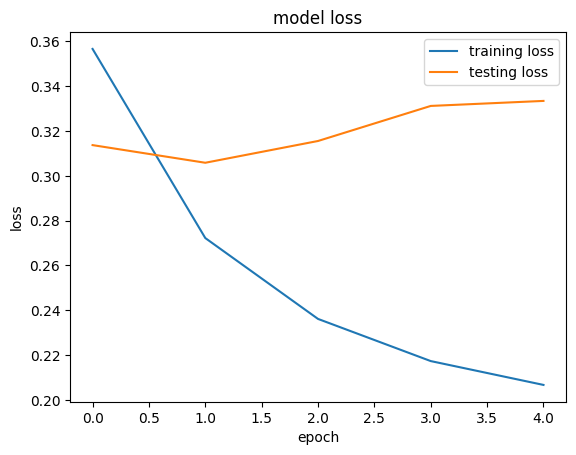

In [67]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="testing loss")
plt.title("model loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

predict the model

In [68]:
y_pred = model.predict(x_test)
y_pred.shape

4539/4539 ━━━━━━━━━━━━━━━━━━━━ 70s 15ms/step


(145224, 1)

In [69]:
y_pred = y_pred.squeeze()

In [70]:
y_pred_binary = np.where(y_pred>0.5,1,0)
y_pred_binary

array([1, 1, 1, ..., 1, 0, 1])

In [71]:
loss,accuracy = model.evaluate(x_test, y_test)
print("model loss",loss)
print("model accuracy",accuracy)

4539/4539 ━━━━━━━━━━━━━━━━━━━━ 67s 15ms/step - accuracy: 0.8619 - loss: 0.3336
model loss 0.3334115743637085
model accuracy 0.862205982208252


In [72]:
from sklearn.metrics import accuracy_score,confusion_matrix
print(f"the accuracy score is:{accuracy_score(y_pred_binary,y_test)}")

the accuracy score is:0.8622059714647716


Visualize the confusion matrix

<Axes: >

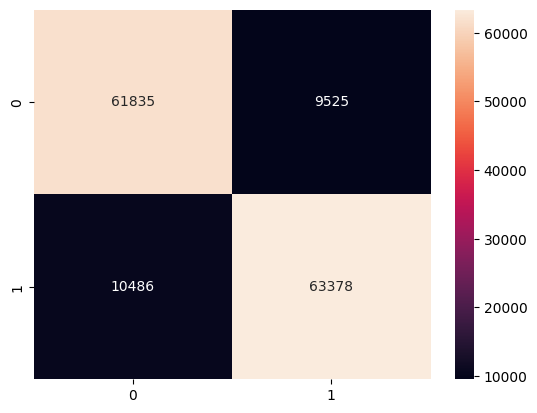

In [73]:
import seaborn as sns
con= confusion_matrix(y_pred_binary,y_test)
sns.heatmap(con,annot=True,fmt='d')